In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

In [2]:
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

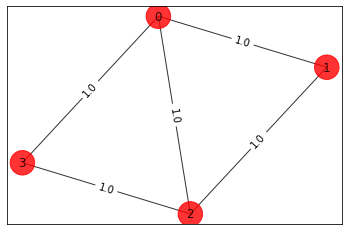

In [3]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0
16

Best solution = [1, 0, 1, 0] cost = 4.0


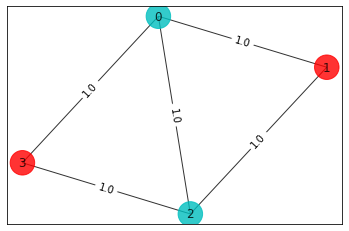

In [5]:
###
# Brute force
###

# Try all possible 2n combinations. For n=4, 
# as in this example, one deals with only 16 combinations, 
# but for n = 1000, one has 1.071509e+30 combinations, 
# which is impractical to deal with by using a brute force approach.
best_cost_brute = 0
iterations = 0;
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    iterations += 1
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

print(iterations)    

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [6]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



In [7]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


In [8]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


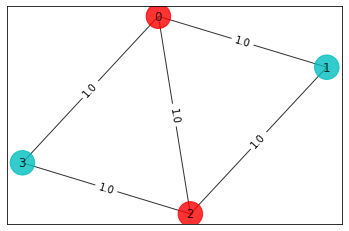

In [9]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [10]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.4999796718929814
time: 2.3391597270965576
max-cut objective: -3.9999796718929814
solution: [1. 0. 1. 0.]
solution objective: 4.0


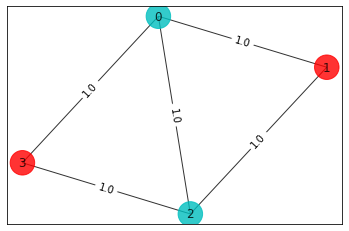

In [11]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


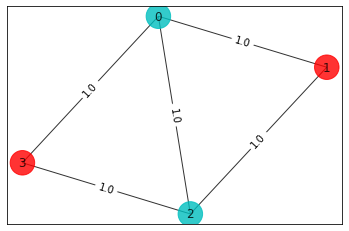

In [12]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

# TSP

In [13]:
import logging
from collections import namedtuple

import numpy as np
from qiskit.quantum_info import Pauli

from qiskit.aqua import aqua_globals
from qiskit.aqua.operators import WeightedPauliOperator

def get_operator(ins, penalty=1e5):
    """Generate Hamiltonian for TSP of a graph.

    Args:
        ins (TspData) : TSP data including coordinates and distances.
        penalty (float) : Penalty coefficient for the constraints

    Returns:
        tuple(WeightedPauliOperator, float): operator for the Hamiltonian and a
        constant shift for the obj function.

    """
    counter = 1
    num_nodes = ins.dim
    num_qubits = num_nodes ** 2
    zero = np.zeros(num_qubits, dtype=bool)
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            for p__ in range(num_nodes):
                counter +=1
                q = (p__ + 1) % num_nodes
                shift += ins.w[i, j] / 4

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                pauli_list.append([-ins.w[i, j] / 4, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[j * num_nodes + q] = True
                pauli_list.append([-ins.w[i, j] / 4, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                z_p[j * num_nodes + q] = True
                pauli_list.append([ins.w[i, j] / 4, Pauli(z_p, zero)])

    for i in range(num_nodes):
        for p__ in range(num_nodes):
            counter +=1
            z_p = np.zeros(num_qubits, dtype=bool)
            z_p[i * num_nodes + p__] = True
            pauli_list.append([penalty, Pauli(z_p, zero)])
            shift += -penalty

    for p__ in range(num_nodes):
        for i in range(num_nodes):
            for j in range(i):
                counter +=1
                shift += penalty / 2

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                pauli_list.append([-penalty / 2, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[j * num_nodes + p__] = True
                pauli_list.append([-penalty / 2, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                z_p[j * num_nodes + p__] = True
                pauli_list.append([penalty / 2, Pauli(z_p, zero)])

    for i in range(num_nodes):
        for p__ in range(num_nodes):
            for q in range(p__):
                counter +=1
                shift += penalty / 2

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                pauli_list.append([-penalty / 2, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + q] = True
                pauli_list.append([-penalty / 2, Pauli(z_p, zero)])

                z_p = np.zeros(num_qubits, dtype=bool)
                z_p[i * num_nodes + p__] = True
                z_p[i * num_nodes + q] = True
                pauli_list.append([penalty / 2, Pauli(z_p, zero)])
    shift += 2 * penalty * num_nodes
    print(counter)
    return WeightedPauliOperator(paulis=pauli_list), shift

In [14]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

In [15]:
from itertools import permutations

def brute_force_tsp(w, N):
    counter = 0
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            counter += 1
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    print(counter)
    return last_best_distance, best_order

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


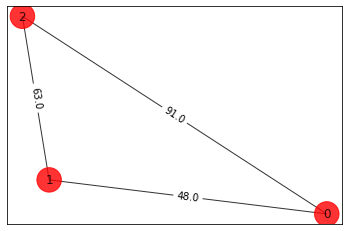

In [16]:
# Generating a graph of 3 nodes
n = 3 #12
num_qubits = n ** 2
ins = tsp.random_tsp(n, seed=123)
print('distance\n', ins.w)

# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])

pos = {k: v for k, v in enumerate(ins.coord)}

draw_graph(G, colors, pos)

order = (0, 1, 2) Distance = 202.0
4
Best order from brute force = (0, 1, 2) with total distance = 202.0


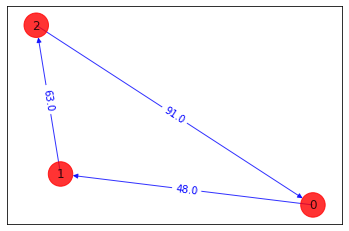

In [17]:
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))
draw_tsp_solution(G, best_order, colors, pos)

In [18]:
qubitOp, offset = get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

46
Offset: 600303.0
Ising Hamiltonian:
IIIIIIIIZ	(-100069.5+0j)
IIIIZIIII	(-100055.5+0j)
IIIIZIIIZ	(12+0j)
IIIIIIIZI	(-100069.5+0j)
IIIZIIIII	(-100055.5+0j)
IIIZIIIZI	(12+0j)
IIIIIIZII	(-100069.5+0j)
IIIIIZIII	(-100055.5+0j)
IIIIIZZII	(12+0j)
IZIIIIIII	(-100077+0j)
IZIIIIIIZ	(22.75+0j)
ZIIIIIIII	(-100077+0j)
ZIIIIIIZI	(22.75+0j)
IIZIIIIII	(-100077+0j)
IIZIIIZII	(22.75+0j)
IIIIIZIZI	(12+0j)
IIIIZIZII	(12+0j)
IIIZIIIIZ	(12+0j)
IZIIIZIII	(15.75+0j)
ZIIIZIIII	(15.75+0j)
IIZZIIIII	(15.75+0j)
IIZIIIIZI	(22.75+0j)
IZIIIIZII	(22.75+0j)
ZIIIIIIIZ	(22.75+0j)
IIZIZIIII	(15.75+0j)
IZIZIIIII	(15.75+0j)
ZIIIIZIII	(15.75+0j)
IIIIIZIIZ	(50000+0j)
IIZIIIIIZ	(50000+0j)
IIZIIZIII	(50000+0j)
IIIIZIIZI	(50000+0j)
IZIIIIIZI	(50000+0j)
IZIIZIIII	(50000+0j)
IIIZIIZII	(50000+0j)
ZIIIIIZII	(50000+0j)
ZIIZIIIII	(50000+0j)
IIIIIIIZZ	(50000+0j)
IIIIIIZIZ	(50000+0j)
IIIIIIZZI	(50000+0j)
IIIIZZIII	(50000+0j)
IIIZIZIII	(50000+0j)
IIIZZIIII	(50000+0j)
IZZIIIIII	(50000+0j)
ZIZIIIIII	(50000+0j)
ZZIIIIIII	(50000+0j)



In [19]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 200000 x_0 - 200000 x_1 - 200000 x_2 - 200000 x_3 - 200000 x_4 - 200000 x_5
 - 200000 x_6 - 200000 x_7 - 200000 x_8 [ 200000 x_0*x_1 + 200000 x_0*x_2
 + 200000 x_0*x_3 + 48 x_0*x_4 + 48 x_0*x_5 + 200000 x_0*x_6 + 91 x_0*x_7
 + 91 x_0*x_8 + 200000 x_1*x_2 + 48 x_1*x_3 + 200000 x_1*x_4 + 48 x_1*x_5
 + 91 x_1*x_6 + 200000 x_1*x_7 + 91 x_1*x_8 + 48 x_2*x_3 + 48 x_2*x_4
 + 200000 x_2*x_5 + 91 x_2*x_6 + 91 x_2*x_7 + 200000 x_2*x_8 + 200000 x_3*x_4
 + 200000 x_3*x_5 + 200000 x_3*x_6 + 63 x_3*x_7 + 63 x_3*x_8 + 200000 x_4*x_5
 + 63 x_4*x_6 + 200000 x_4*x_7 + 63 x_4*x_8 + 63 x_5*x_6 + 63 x_5*x_7
 + 200000 x_5*x_8 + 200000 x_6*x_7 + 200000 x_6*x_8 + 200000 x_7*x_8 ] +
 600000;
 
subject to {

}


In [20]:
result = exact.solve(qp)
print(result)

optimal function value: 202.0
optimal value: [1. 0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS


energy: -600101.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


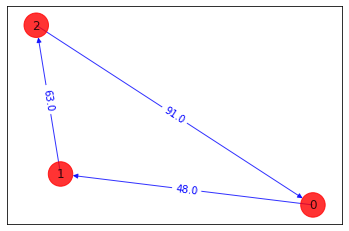

In [21]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [22]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -587129.7995590201
time: 7.934804439544678
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


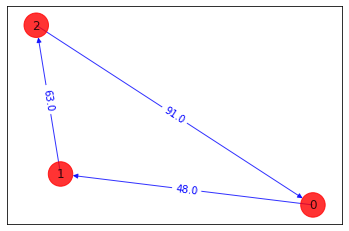

In [23]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [24]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

optimal function value: 202.0
optimal value: [0. 0. 1. 0. 1. 0. 1. 0. 0.]
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


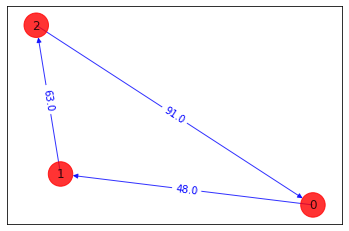

In [25]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)